# Training e Test con SARSA
In questo notebook è presente il training di Q*Bert sfruttando l'algoritmo SARSA

## Download Repository

Download della repository per utilizzare le classi create su Google Colab

In [1]:
from google.colab import userdata

In [2]:
!git clone https://{userdata.get('TokenGithub')}"@github.com/amigli/Q-Bert_RL.git"

Cloning into 'Q-Bert_RL'...
remote: Enumerating objects: 435, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (128/128), done.
Receiving objects: 100% (435/435), 8.19 MiB | 15.36 MiB/s, done.
remote: Total 435 (delta 101), reused 49 (delta 24), pack-reused 283 (from 1)
Resolving deltas: 100% (265/265), done.


In [3]:
%cd Q-Bert_RL/

/content/Q-Bert_RL


## Installazione dei requirements

Vengono installati tutti i moduli necessari dal file requirements.txt

In [4]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 21.4 MB/s eta 0:00:00


In [5]:
!pip install ale-py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 40.9 MB/s eta 0:00:00


In [6]:
!pip install moviepy

## Settings per video

In [7]:
directory_videos = '/content/Videos/'

## Algoritmo

In [8]:
from Algorithms.QBertAgent_SARSA import SARSAAgent
import gymnasium as gym
import ale_py
from tqdm.notebook import tqdm
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo
from EnvironmentWrappers.QbertObservationWrapper import QbertObservationWrapperTuple
from EnvironmentWrappers.RewardFunction import RewardFunction
from EnvironmentWrappers.ObsRewardWrapper import ObsRewardWrapper

In [9]:
gym.register_envs(ale_py)

In [21]:
# hyperparameters
step_size = 0.01
n_episodes = 5000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)
final_epsilon = 0.1

### Training

In [22]:
env = gym.make("ALE/Qbert-ram-v5")
env =  ObsRewardWrapper(env)
env = RecordEpisodeStatistics(env, buffer_length=n_episodes)
agent = SARSAAgent(
    env=env,
    step_size=step_size,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [23]:
rewards = []

In [24]:
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False
    obs = tuple(obs)
    # print("Episode:" + str(episode))
    total_reward = 0
    action = agent.get_action(obs, True)

    while not done:
        # print(action)
        next_obs, reward, terminated, truncated, info = env.step(action)
        next_obs = tuple(next_obs)
        # print("Reward: " + str(reward))
        # print("action: " + str(action))
        next_action = agent.get_action(next_obs, True)
        total_reward += reward
        # update the agent
        agent.update(obs, action, reward, terminated, next_obs, next_action)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs
        action = next_action

    agent.decay_epsilon()

  0%|          | 0/5000 [00:00<?, ?it/s]

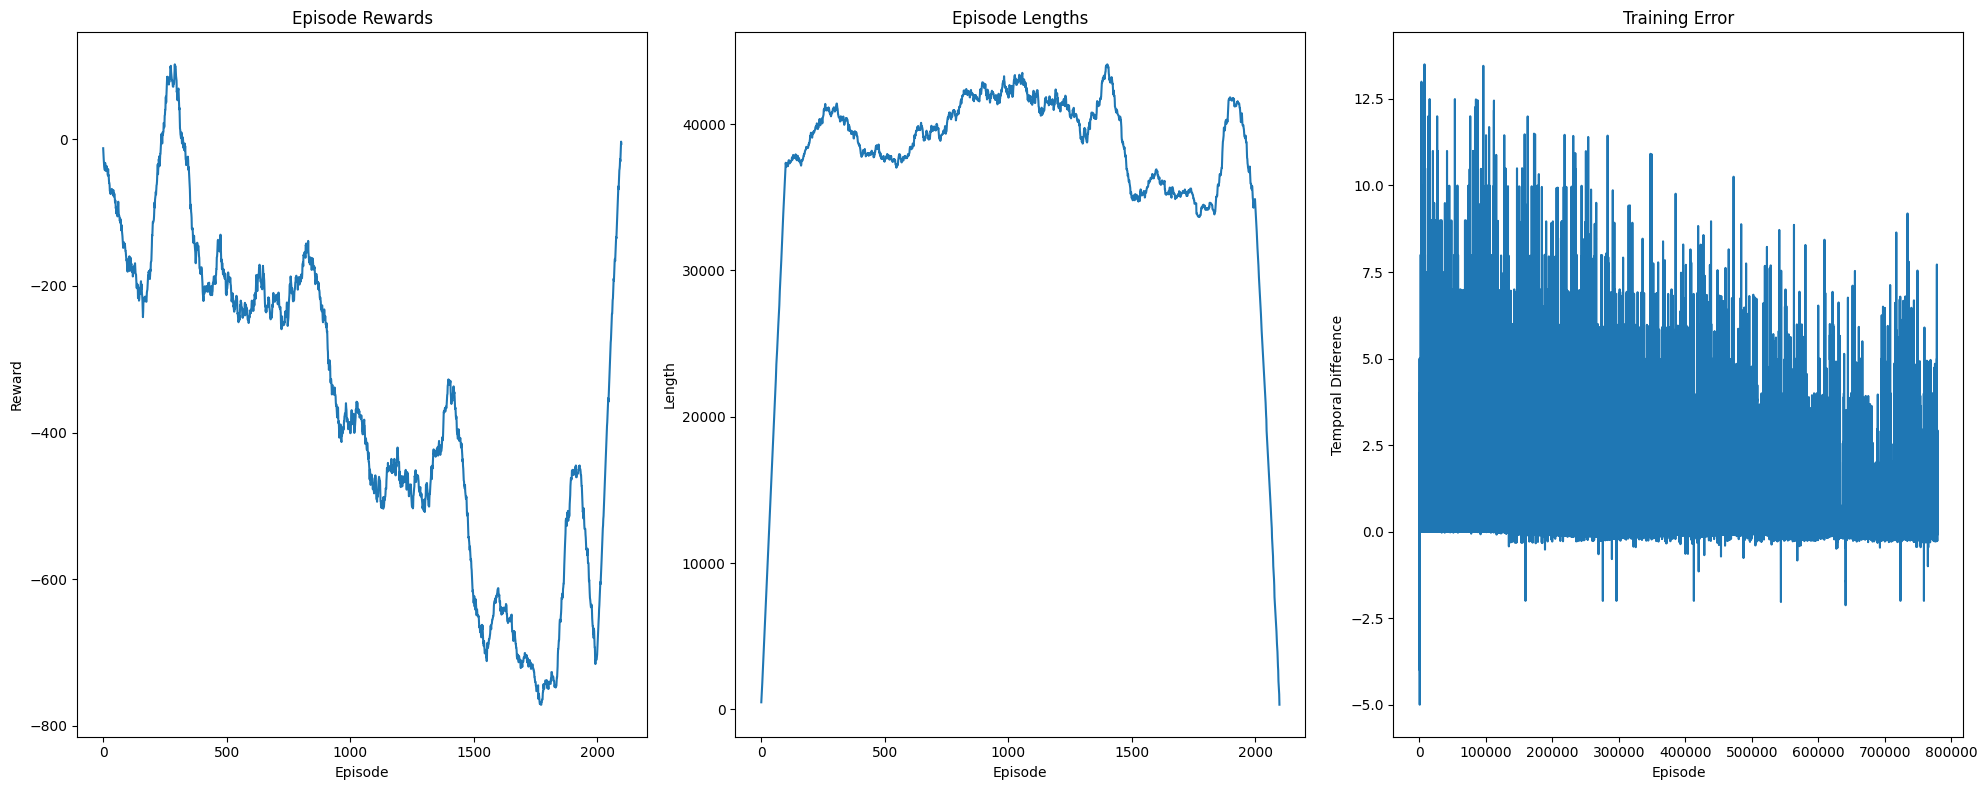

In [16]:
from matplotlib import pyplot as plt
import numpy as np

# visualize the episode rewards, episode length and training error in one figure
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

# np.convolve will compute the rolling mean for 100 episodes

axs[0].plot(np.convolve(env.return_queue, np.ones(100)))
axs[0].set_title("Episode Rewards")
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Reward")

axs[1].plot(np.convolve(env.length_queue, np.ones(100)))
axs[1].set_title("Episode Lengths")
axs[1].set_xlabel("Episode")
axs[1].set_ylabel("Length")

axs[2].plot(np.convolve(agent.training_error, np.ones(100)))
axs[2].set_title("Training Error")
axs[2].set_xlabel("Episode")
axs[2].set_ylabel("Temporal Difference")

plt.tight_layout()
plt.show()

In [17]:
env.close()

### Registrazione episodi

In [18]:
num_eval_episodes = 10

env = gym.make("ALE/Qbert-ram-v5", render_mode="rgb_array")
env =  QbertObservationWrapperTuple(env)
env = RecordVideo(env, video_folder="videos_first", name_prefix="eval",
                  episode_trigger=lambda x: True)
env = RecordEpisodeStatistics(env, buffer_length=num_eval_episodes)

In [19]:
for episode_num in range(num_eval_episodes):
    obs, info = env.reset()
    rewardFunction = RewardFunction(obs[0])
    obs = obs[1]
    done = False

    while not done:
        action = agent.get_action(obs, False)
        next_obs, reward, terminated, truncated, info = env.step(action)
        reward = rewardFunction.calculate_reward(next_obs, reward)
        obs =  next_obs[1]

        done = terminated or truncated
env.close()

In [20]:
print(f'Episode time taken: {env.time_queue}')
print(f'Episode total rewards: {env.return_queue}')
print(f'Episode lengths: {env.length_queue}')
print("Training terminato")

Episode time taken: deque([0.77556, 0.794666, 0.64306, 0.735244, 0.649661, 0.616923, 0.708709, 0.654956, 0.622909, 0.802817], maxlen=10)
Episode total rewards: deque([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], maxlen=10)
Episode lengths: deque([1038, 1038, 1038, 1038, 1038, 1038, 1038, 1038, 1038, 1038], maxlen=10)
Training terminato
